In [17]:
#library imports
import math
from collections import namedtuple
import numpy as np
from sympy import symbols
import matplotlib.pyplot as plt

In [18]:
#some boilerplate code
x = symbols('x')
Equation = namedtuple('Equation',('a','b','c'))
Conditions = namedtuple('Conditions',('x0','xn','h'))
Boundary = namedtuple('Boundary', ('alpha', 'beta', 'gamma'))

In [28]:
def Finite_Diff_Solver(eq, bc0, bcn, cond, verbose=True):
    n = int(np.ceil((cond.xn - cond.x0)/cond.h))
    a, b, c, d = np.zeros((n-2)), np.zeros((n-1)), np.zeros((n-2)), np.zeros((n-1))
    #A
    b[0] = -2.0 / cond.h**2 + eq.b.subs(x, (cond.x0 + cond.h)) -\
    2.0 * bc0.beta * (1.0 / cond.h**2 - eq.a.subs(x, (cond.x0 + cond.h)) /\
    (2.0 * cond.h)) / (bc0.alpha * cond.h - 1.5 * bc0.beta)
    c[0] = 1.0 / cond.h**2 + eq.a.subs(x, (cond.x0 + cond.h)) / (2.0 * cond.h) +\
    0.5 * bc0.beta * (1.0 / cond.h**2 - eq.a.subs(x, (cond.x0 + cond.h)) /\
    (2.0 * cond.h)) / (bc0.alpha * cond.h - 1.5 * bc0.beta)
    a[n-3] = 1.0 / cond.h**2 - eq.a.subs(x, (cond.xn - cond.h)) / (2.0 * cond.h) -\
    0.5 * bcn.beta * (1.0 / cond.h**2 + eq.a.subs(x, (cond.xn - cond.h)) /\
    (2.0 * cond.h)) / (bcn.alpha * cond.h + 1.5 * bcn.beta)
    b[n-2] = -2.0 / cond.h**2 + eq.b.subs(x, (cond.xn - cond.h)) +\
    2.0 * bcn.beta * (1.0 / cond.h**2 + eq.a.subs(x, (cond.xn - cond.h)) /\
    (2.0 * cond.h)) / (bcn.alpha * cond.h + 1.5 * bcn.beta)
    #d
    d[0] = eq.c.subs(x, (cond.x0 + cond.h)) -\
    bc0.gamma * (1.0 / cond.h**2 - eq.a.subs(x, (cond.x0 + cond.h)) /\
    (2.0 * cond.h)) / (bc0.alpha - 1.5 * bc0.beta / cond.h)
    d[n-2] = eq.c.subs(x, (cond.xn-cond.h)) -\
    bcn.gamma * (1.0 / cond.h**2 + eq.a.subs(x, (cond.xn - cond.h)) /\
    (2.0 * cond.h)) / (bcn.alpha + 1.5 * bcn.beta / cond.h)
    for i, xi in enumerate(np.arange(cond.x0 + 2*cond.h, cond.xn - cond.h, cond.h),\
                           start=1):
        a[i-1] = 1.0 / cond.h**2 - eq.a.subs(x, xi) / (2.0*cond.h)
        b[i] = -2.0 / cond.h**2 + eq.b.subs(x, xi)
        c[i] = 1.0 / cond.h**2 + eq.a.subs(x, xi) / (2.0*cond.h)
        d[i] = eq.c.subs(x,xi)
    
    def tridiag(a, b, c, k1=-1, k2=0, k3=1):
        return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
    if verbose:
        print("A={}".format(tridiag(a,b,c)))
        print("d={}".format(d.T))
    return (a,b,c,d)

In [37]:
def Thomas_Algorithm(coeff, bc0, bcn, cond):
    a, b, c, d = coeff
    n = int(np.ceil((cond.xn - cond.x0)/cond.h))
    c1 = np.zeros((n-2))
    d1 = np.zeros((n-1))
    c1[0] = c[0]/b[0]
    d1[0] = d[0]/b[0]
    for i in range(1,n-2):
        c1[i] = c[i]/(b[i]-a[i-1]*c1[i-1])
        d1[i] = (d[i] - a[i-1] * d1[i-1])/(b[i]-a[i-1]*c1[i-1])
    d1[n-2] = (d[n-2] - a[n-3] * d1[n-3])/(b[n-2] - a[n-3]*c1[n-3])
    def backsubstitution(c,d):
        y = np.zeros_like(d)
        y[-1] = d[-1]
        cache = y[-1]
        for i in reversed(range(d.shape[0]-1)):
            y[i] = d[i] - cache * c[i]
            cache = y[i]
        return y
    fin_y = backsubstitution(c1,d1)
    y0 = (bc0.gamma - 2.0 * bc0.beta * fin_y[0] / cond.h +\
    0.5 * bc0.beta * fin_y[1] / cond.h) / (bc0.alpha - 1.5 * bc0.beta / cond.h)
    yn = (bcn.gamma + 2.0 * bcn.beta * fin_y[-1] / cond.h -\
    0.5 * bcn.beta * fin_y[-2] / cond.h) / (bcn.alpha + 1.5 * bcn.beta / cond.h)
    y = np.append(fin_y, yn)
    y = np.append(y0, y)
    return y
    

In [38]:
%%latex
\begin{align}
\theta'' -\lambda\theta = 0\\
x \in (0,1) \\
\theta(0) = 1\\
\theta'(1) = 0 \\
\lambda = 2
\end{align}

<IPython.core.display.Latex object>

In [39]:
#Equations & Boundary Conditions
eqn = Equation(0.0 + 0.0*x,-2.0 + x*0.0,0.0 + 0.0*x)
cond = Conditions(0,1,0.25)
bc1 = Boundary(1,0,1)
bc2 = Boundary(0,1,0)
tuples_coeff = Finite_Diff_Solver(eqn, bc1, bc2, cond, verbose=False)
y1 = Thomas_Algorithm(tuples_coeff, bc1, bc2, cond)
x_range1 = np.arange(cond.x0, cond.xn+cond.h, cond.h)

def func(x): #original solution
    y = (np.exp((math.sqrt(2.0) * x)) +\
    math.exp((math.sqrt(2.0) * 2.0)) * np.exp((math.sqrt(2.0) * -x))) /\
    (math.exp((math.sqrt(2.0) * 2.0)) + 1.0)
    return y

In [40]:
%%latex
\begin{align}
y'' -2xy' -2y = -4x\\
x \in (0,1) \\
y(0) - y'(0) = 0\\
2y(1) - y'(1) = 1\\
\end{align}

<IPython.core.display.Latex object>

In [41]:
#Equations & Boundary Conditions
eqn = Equation(-2.0*x,-2.0 + x*0.0,-4.0*x)
cond = Conditions(0,1,0.005)
bc1 = Boundary(1,-1,0)
bc2 = Boundary(2,-1,1)
tuples_coeff = Finite_Diff_Solver(eqn, bc1, bc2, cond, verbose=False)
y2 = Thomas_Algorithm(tuples_coeff, bc1, bc2, cond)
x_range2 = np.arange(cond.x0, cond.xn+cond.h, cond.h)

In [42]:
%%latex
\begin{align}
y'' + y = 0\\
x \in (0,1) \\
y(0) = 0\\
y(1) = 1\\
\end{align}

<IPython.core.display.Latex object>

In [43]:
eqn = Equation(0.0 + 0.0*x,1.0 + 0.0*x,0.0*x)
cond = Conditions(0,1,0.1)
bc1 = Boundary(1,0,0)
bc2 = Boundary(1,0,1) 
tuples_coeff = Finite_Diff_Solver(eqn, bc1, bc2, cond, verbose=False)
y3 = Thomas_Algorithm(tuples_coeff, bc1, bc2, cond)
x_range3 = np.arange(cond.x0, cond.xn+cond.h, cond.h)
def func2(x): #original solution
    return np.sin(x)/np.sin(1)

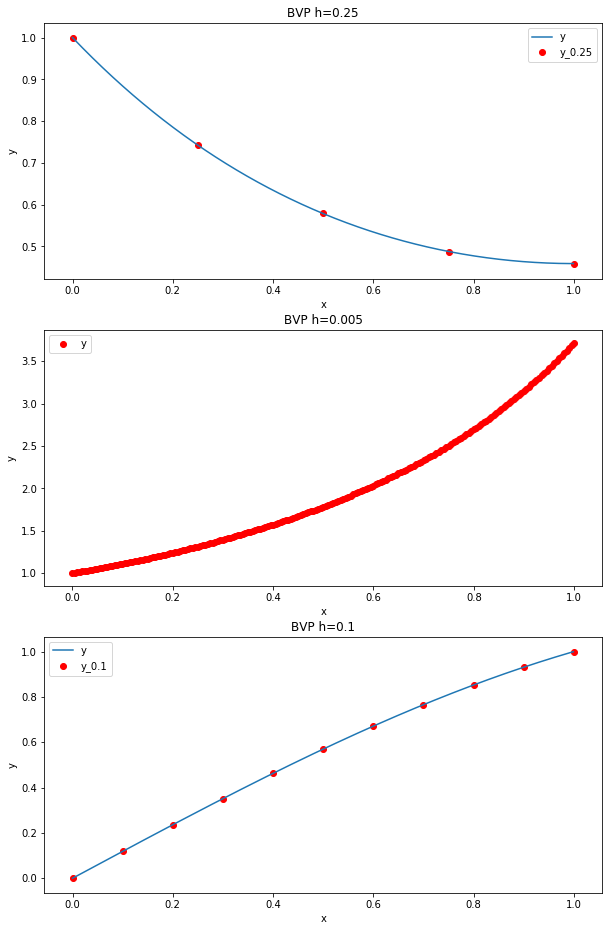

In [44]:
t1 = np.arange(cond.x0, cond.xn, 0.001)

#print(x_range)
fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(311)
ax.plot(t1, func(t1))
ax.set(title="BVP h=0.25", xlabel="x", ylabel="y")
ax.scatter(x_range1, y1, color='red')
ax.legend(('y','y_0.25'))
ax.plot()
ax = fig.add_subplot(312)
ax.set(title="BVP h=0.005", xlabel="x", ylabel="y")
ax.scatter(x_range2, y2, color='red')
ax.legend(('y','y_0.1'))
ax.plot()
ax = fig.add_subplot(313)
ax.plot(t1, func2(t1))
ax.set(title="BVP h=0.1", xlabel="x", ylabel="y")
ax.scatter(x_range3, y3, color='red')
ax.legend(('y','y_0.1'))
ax.plot()
fig.show()